<a id="top"></a>
<div class="list-group" id="list-tab" role="tablist">
<h1 class="list-group-item list-group-item-action active" data-toggle="list" style='background:#005097; border:0' role="tab" aria-controls="home"><center>APRENDIZADO DE MÁQUINA (CIC1205/GCC1932) - Trabalho 1</center></h1>

- Nome completo: MATHEUS SANTOS MELO
- Matrícula: 2430148MCICMA
- [Link para vídeo](<LINK_VIDEO>)

- Para esse trabalho, utilizei a versão do Python 3.12.4.

## 0. Importação das bibliotecas para todas as questões

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.subplots as sp
import plotly.graph_objects as go
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, mean_squared_error, r2_score
import pickle
import warnings

# Para ignorar mensagens de aviso
warnings.filterwarnings(action='ignore')

# Parâmetro para utilizar no random_state
seed = 123

## 1. Predição de pagamento de empréstimos

### Descrição dos dados (Conforme o enunciado)

- **ESCT**: estado civil do cliente (0, 1, 2, 3)

- **NDEP**: número de dependentes do cliente (0 a 7)

- **RENDA**: renda familiar mensal em reais (300–9675)

- **TIPOR**: tipo de residência do cliente (0, 1)

- **VBEM**: valor do bem a ser adquirido (300–6000)

- **NPARC**: número de parcelas para pagamento (1–24)

- **VPARC**: valor de cada parcela (50–719)

- **TEL**: se o cliente possui telefone (0, 1)

- **IDADE**: idade do cliente (18–70)

- **RESMS**: tempo de moradia atual em meses (0–420)

- **ENTRADA**: valor da entrada dada no bem (0–1300)

- **CLASSE**: =1 se o cliente pagou a dívida; =0 caso contrário (0, 1)

### Análise Exploratória dos Dados

In [36]:
col_names = ["ESCT", "NDEP", "RENDA", "TIPOR", "VBEM", "NPARC", "VPARC", "TEL", "IDADE", "RESMS", "ENTRADA", "CLASSE"]

credtrain = pd.read_csv('credtrain.txt', sep='\t', header=None, names=col_names)
credtest = pd.read_csv('credtest.txt', sep='\t', header=None, names=col_names)

In [37]:
credtrain

,ESCT,NDEP,RENDA,TIPOR,VBEM,NPARC,VPARC,TEL,IDADE,RESMS,ENTRADA,CLASSE
0,1,0,360,0,313,9,52,0,25,48,0,1
1,0,0,350,1,468,10,65,0,33,6,0,1
2,0,0,1100,0,829,9,125,0,56,48,0,1
3,0,0,3000,0,552,12,76,1,31,60,0,1
4,1,0,1000,0,809,12,111,0,24,7,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,1,0,500,0,437,12,60,0,60,48,0,1
1496,1,0,2057,0,301,1,318,0,35,48,0,1
1497,0,0,570,0,511,12,71,1,28,144,0,1
1498,0,0,360,0,384,12,52,0,33,36,0,1


In [38]:
credtrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   ESCT     1500 non-null   int64
 1   NDEP     1500 non-null   int64
 2   RENDA    1500 non-null   int64
 3   TIPOR    1500 non-null   int64
 4   VBEM     1500 non-null   int64
 5   NPARC    1500 non-null   int64
 6   VPARC    1500 non-null   int64
 7   TEL      1500 non-null   int64
 8   IDADE    1500 non-null   int64
 9   RESMS    1500 non-null   int64
 10  ENTRADA  1500 non-null   int64
 11  CLASSE   1500 non-null   int64
dtypes: int64(12)
memory usage: 140.8 KB


- Não há nenhum valor nulo que necessite de tratamento. 

- Pela descrição apontada no enunciado, "ESCT", "NDEP", "TIPOR", "TEL" são features categóricas. "NDEP" é uma variável categórica ordinal já tratada respeitando esse quesito e as features "TIPOR" e "TEL" são binárias que já estão codificadas com um rótulo adequado. Porém, a variável "ESCT" é uma variável categórica nominal que apesar de estar em formato númerico, precisa de codificação com One Hot Encoder.

- A respeito das variáveis númericas 'RENDA', 'VBEM', 'NPARC', 'VPARC', 'IDADE', 'RESMS', 'ENTRADA', como se tratam de variáveis com diferença significativa de escala, pode interferir em algoritmos que são sensíveis a escala, como o KNN. Por isso, irei codificá-las utilizando o StandardScaler.

In [39]:
credtrain['CLASSE'].value_counts()

CLASSE
0    785
1    715
Name: count, dtype: int64

- O dataset está balanceado, não necessitando de uma etapa de balanceamento das classes.

### Configurações experimentais (Pré-processamento)

In [40]:
# -------- TREINO E VALIDAÇÃO -------- #

# Divisão do conjunto de treino em X (features) e y (target)
X = credtrain.drop('CLASSE', axis=1)
y = credtrain['CLASSE']

# Criando uma lista de nomes das features númericas que irão ser codificadas com o StandardScaler
numerical_features = ['RENDA', 'VBEM', 'NPARC', 'VPARC', 'IDADE', 'RESMS', 'ENTRADA']

# Criando uma lista com o objetivo de cada algoritmo que será utilizado para realizar as predições 
classifiers = [LogisticRegression(random_state=seed), KNeighborsClassifier(), GradientBoostingClassifier(random_state=seed)]

# Divisão do conjunto de treino em treino/validação com uma porcentagem de treino em 20%
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed)

# Etapa de transformação apenas das features númericas utilizando o StandardScaler
transformer = ColumnTransformer(transformers=[('scaler', StandardScaler(), numerical_features),
                                             ('onehot_encoder', OneHotEncoder(), ["ESCT"])],
                                             remainder='passthrough')


# Realizando a transformação nas features de treino e validação da forma correta para evitar data leakage
X_train = transformer.fit_transform(X_train)
X_val = transformer.transform(X_val)


# --------- TESTE --------------- #

# Divisão do conjunto de teste em X (features) e y (target)
X_test = credtest.drop('CLASSE', axis=1)
y_test = credtest['CLASSE']

# Reutilizando a transformação feita nas features de treino anteriormente da forma correta para evitar data leakage
X_test = transformer.transform(X_test)

### Modelagem preditiva

#### Funções que serão utilizadas nessa etapa (Adaptadas dos notebooks de aula)

In [41]:
# Plot the confusion matrices for different thresholds
def plot_confusion_matrix(ax, results, title):
    cm = np.array([
        [results["confusion_matrix"]["TN"], results["confusion_matrix"]["FP"]],
        [results["confusion_matrix"]["FN"], results["confusion_matrix"]["TP"]]
    ])
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Negative', 'Positive'])
    ax.set_yticklabels(['Negative', 'Positive'])

    # Add text annotations
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="white" if cm[i, j] > cm.max()/2 else "black")

    return im

In [42]:
# Evaluate model at different thresholds
def evaluate_threshold(y_true, y_scores, threshold):
    """Evaluate model performance at a given threshold"""
    y_pred = (y_scores >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    return {
        "threshold": threshold,
        "classification_report": classification_report(y_true, y_pred),
        "confusion_matrix": {
            "TP": tp, "FP": fp,
            "TN": tn, "FN": fn
        }
    }

In [43]:
# Function to find the optimal threshold based on different criteria
def find_optimal_threshold(fpr, tpr, thresholds):
    """
    Find the optimal threshold using different methods:
    1. Youden's J statistic (maximizes TPR - FPR)
    2. Closest point to (0,1)
    """
    # Youden's J statistic (maximizing TPR - FPR)
    j_scores = tpr - fpr
    j_optimal_idx = np.argmax(j_scores)
    j_optimal_threshold = thresholds[j_optimal_idx]

    # Point closest to (0,1) in the ROC space
    distances = np.sqrt((1-tpr)**2 + fpr**2)
    closest_optimal_idx = np.argmin(distances)
    closest_optimal_threshold = thresholds[closest_optimal_idx]

    return {
        "youden": (j_optimal_threshold, j_optimal_idx),
        "closest": (closest_optimal_threshold, closest_optimal_idx)
    }

#### Treino e validação dos modelos e escolha do Threshold ótimo

Classificador: LogisticRegression(random_state=123)
Comparison of Thresholds:
--------------------------------------------------
Default (0.5):
              precision    recall  f1-score   support

           0       0.83      0.95      0.89       147
           1       0.94      0.82      0.87       153

    accuracy                           0.88       300
   macro avg       0.89      0.88      0.88       300
weighted avg       0.89      0.88      0.88       300


Youden's J (0.4408):
              precision    recall  f1-score   support

           0       0.86      0.94      0.90       147
           1       0.94      0.85      0.89       153

    accuracy                           0.89       300
   macro avg       0.90      0.89      0.89       300
weighted avg       0.90      0.89      0.89       300


Closest to (0,1) (0.4090):
              precision    recall  f1-score   support

           0       0.87      0.93      0.89       147
           1       0.92      0.86      0.89

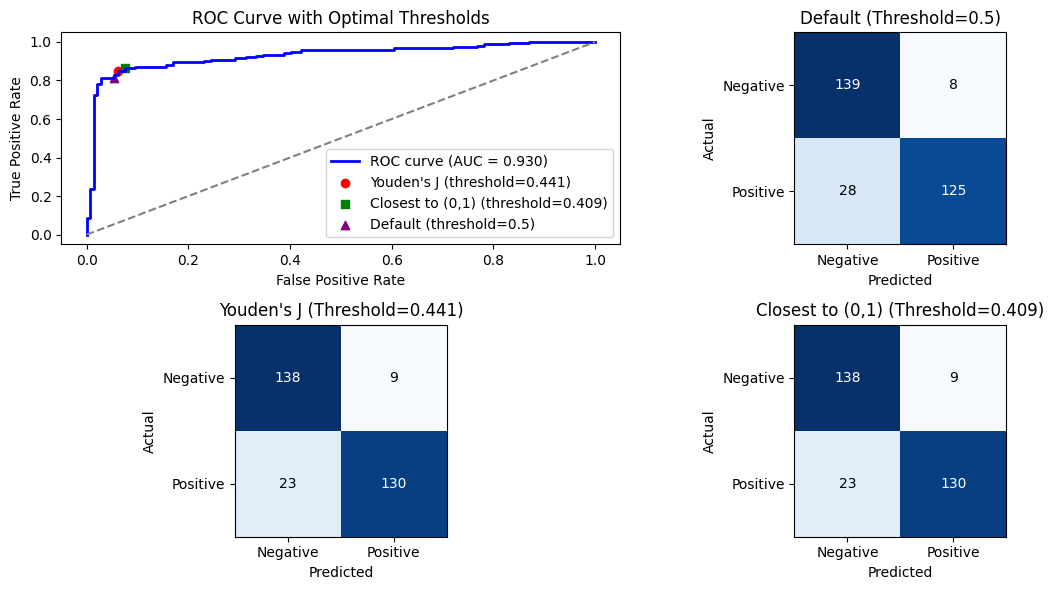

Classificador: KNeighborsClassifier()
Comparison of Thresholds:
--------------------------------------------------
Default (0.5):
              precision    recall  f1-score   support

           0       0.78      0.94      0.85       147
           1       0.93      0.75      0.83       153

    accuracy                           0.84       300
   macro avg       0.86      0.85      0.84       300
weighted avg       0.86      0.84      0.84       300


Youden's J (0.6000):
              precision    recall  f1-score   support

           0       0.78      0.94      0.85       147
           1       0.93      0.75      0.83       153

    accuracy                           0.84       300
   macro avg       0.86      0.85      0.84       300
weighted avg       0.86      0.84      0.84       300


Closest to (0,1) (0.6000):
              precision    recall  f1-score   support

           0       0.78      0.94      0.85       147
           1       0.93      0.75      0.83       153

  

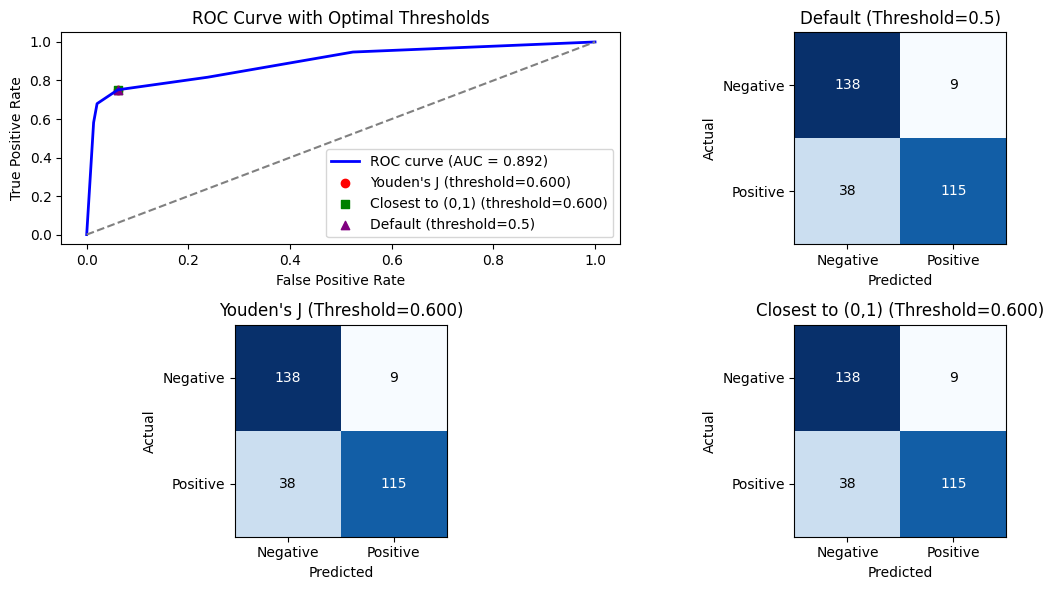

Classificador: GradientBoostingClassifier(random_state=123)
Comparison of Thresholds:
--------------------------------------------------
Default (0.5):
              precision    recall  f1-score   support

           0       0.84      0.96      0.90       147
           1       0.95      0.82      0.88       153

    accuracy                           0.89       300
   macro avg       0.90      0.89      0.89       300
weighted avg       0.90      0.89      0.89       300


Youden's J (0.3650):
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       147
           1       0.95      0.85      0.90       153

    accuracy                           0.90       300
   macro avg       0.90      0.90      0.90       300
weighted avg       0.90      0.90      0.90       300


Closest to (0,1) (0.3650):
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       147
           1       0.95      0.85  

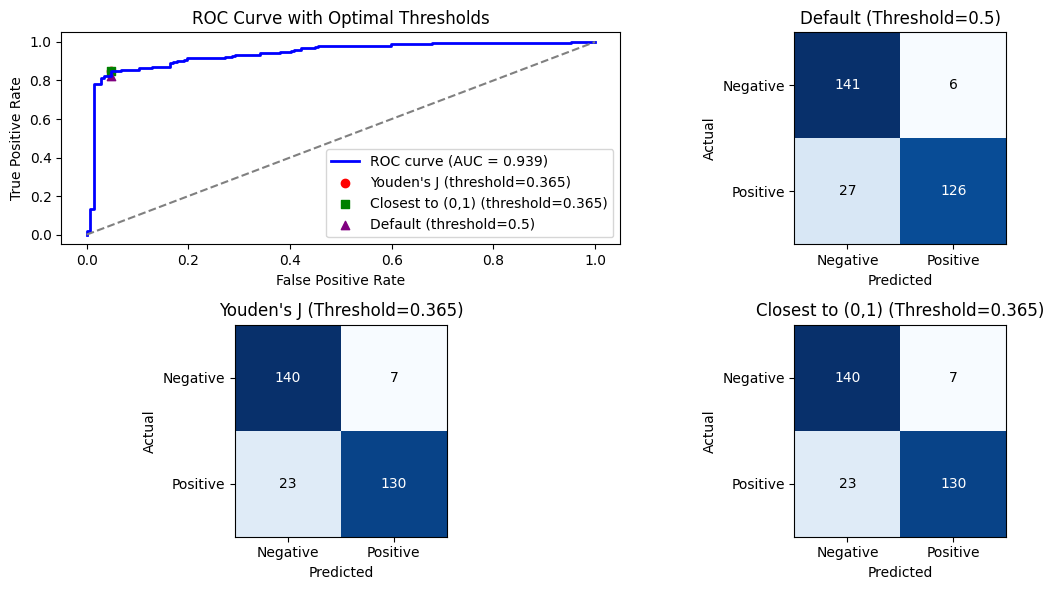

In [44]:
for clf in classifiers:
    print(f'Classificador: {clf}')
    clf.fit(X_train, y_train)

    y_scores = clf.predict_proba(X_val)[:, 1]

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_val, y_scores)

    # Calculate AUC (Area Under Curve)
    roc_auc = auc(fpr, tpr)

    # Find optimal thresholds
    optimal_thresholds = find_optimal_threshold(fpr, tpr, thresholds)

    # Evaluate different thresholds
    default_results = evaluate_threshold(y_val, y_scores, 0.5)
    youden_results = evaluate_threshold(y_val, y_scores, optimal_thresholds["youden"][0])
    closest_results = evaluate_threshold(y_val, y_scores, optimal_thresholds["closest"][0])

    # Visualize ROC curve and optimal thresholds
    plt.figure(figsize=(12, 6))

    # Plot ROC curve
    plt.subplot(2, 2, 1)
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

    # Mark optimal points
    youden_idx = optimal_thresholds["youden"][1]
    closest_idx = optimal_thresholds["closest"][1]

    plt.scatter(fpr[youden_idx], tpr[youden_idx], marker='o', color='red',
            label=f"Youden's J (threshold={optimal_thresholds['youden'][0]:.3f})")
    plt.scatter(fpr[closest_idx], tpr[closest_idx], marker='s', color='green',
            label=f"Closest to (0,1) (threshold={optimal_thresholds['closest'][0]:.3f})")

    # Default threshold of 0.5
    default_idx = np.abs(thresholds - 0.5).argmin()
    plt.scatter(fpr[default_idx], tpr[default_idx], marker='^', color='purple',
            label=f"Default (threshold=0.5)")

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve with Optimal Thresholds')
    plt.legend(loc="lower right")

    # Visualize ROC curve and optimal thresholds and plot confusion matrices for each threshold
    plt.subplot(2, 2, 2)
    plot_confusion_matrix(plt.gca(), default_results, f"Default (Threshold=0.5)")

    plt.subplot(2, 2, 3)
    plot_confusion_matrix(plt.gca(), youden_results, f"Youden's J (Threshold={optimal_thresholds['youden'][0]:.3f})")

    plt.subplot(2, 2, 4)
    plot_confusion_matrix(plt.gca(), youden_results, f"Closest to (0,1) (Threshold={optimal_thresholds['closest'][0]:.3f})")

    plt.tight_layout()

    # Print summary of results
    print("Comparison of Thresholds:")
    print("-" * 50)

    print(f"Default (0.5):")
    print(default_results['classification_report'])

    print(f"\nYouden's J ({optimal_thresholds['youden'][0]:.4f}):")
    print(youden_results['classification_report'])

    print(f"\nClosest to (0,1) ({optimal_thresholds['closest'][0]:.4f}):")
    print(closest_results['classification_report'])

    # Show the plots
    plt.show()

- Acima, podemos observar o treinamento e validação de cada um dos algoritmos de aprendizado de máquina designados para essa questão: **Logistic Regression**, **KNN** e **Gradient Boosting**, com diferentes técnicas de seleção do threshold ótimo conforme aprendido em sala de aula — sendo elas o **Youden's J** e o **Closest to (0,1)**. Essas técnicas são úteis para encontrar um resultado que possa ser superior ao valor padrão de 0.5, o qual também foi analisado para verificar se a otimização realmente traz melhorias relevantes a serem consideradas na avaliação final a seguir.  
  Para cada um dos classificadores mencionados, eu plotei a curva ROC com destaque para o valor da **área sob a curva (AUC)**, que permite quantificar o desempenho geral com base nos valores de ROC. Além disso, destaquei visualmente a posição do threshold ótimo de cada uma das técnicas aplicadas.

- **Análise para avaliação final**:

  1. **Logistic Regression**:  
     Apresentou um AUC-ROC de **93%** e seus resultados foram superiores com um threshold diferente do padrão 0.5, alcançando uma acurácia de **89%**. Como tanto o **Youden's J** (Threshold = 0.441) quanto o **Closest to (0,1)** (Threshold = 0.409) apresentaram resultados iguais, optei por utilizar o threshold ótimo do **Youden's J** na avaliação final desse algoritmo.

  2. **KNN**:  
     Obteve um AUC-ROC de **89.2%** e, mesmo com a otimização do threshold, os resultados permaneceram iguais aos do threshold padrão com uma acurácia de **84**%. Ainda assim, adotarei o threshold encontrado via **Youden's J** (Threshold = 0.6) para a avaliação final com esse algoritmo.

  3. **Gradient Boosting**:  
     Apresentou um AUC-ROC de **93.9%**, sendo o maior desempenho entre os três algoritmos avaliados. O melhor resultado foi alcançado com o ajuste do threshold utilizando tanto o **Youden's J** 
     quanto o **Closest to (0,1)**, ambos no Threshold = 0.365 e com uma acurácia de **90%**. De qualquer forma, irei escolher o **Youden's J** também.


### Avaliação Final dos Modelos

Classificador: LogisticRegression(random_state=123)
Avaliação final
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.91      0.88       306
           1       0.89      0.83      0.86       271

    accuracy                           0.87       577
   macro avg       0.87      0.87      0.87       577
weighted avg       0.87      0.87      0.87       577



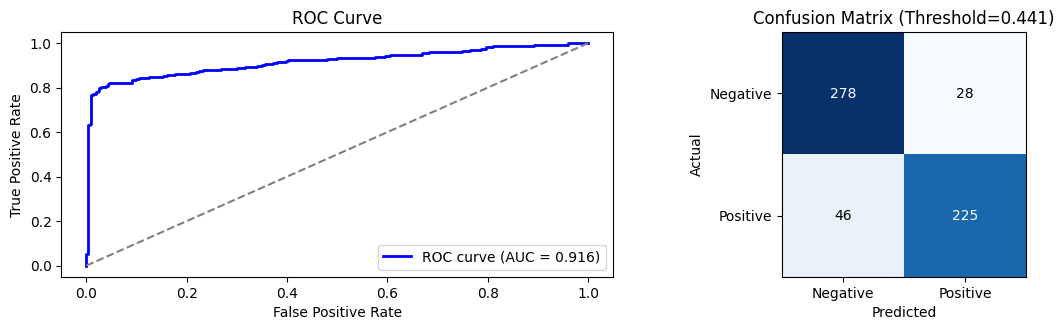

Classificador: KNeighborsClassifier()
Avaliação final
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       306
           1       0.89      0.78      0.83       271

    accuracy                           0.85       577
   macro avg       0.86      0.85      0.85       577
weighted avg       0.86      0.85      0.85       577



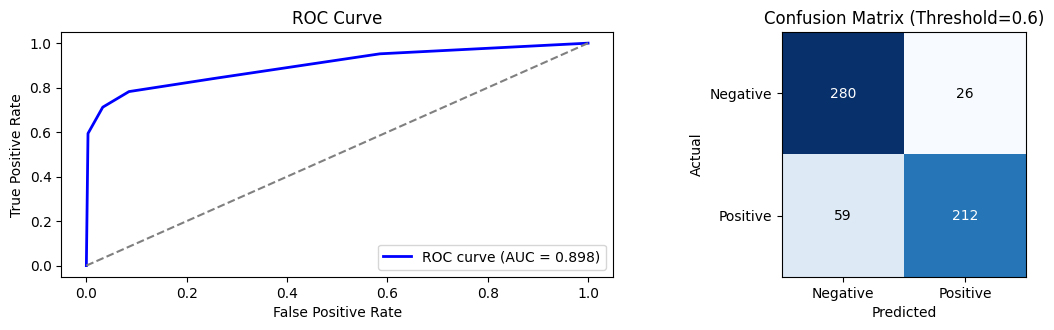

Classificador: GradientBoostingClassifier(random_state=123)
Avaliação final
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       306
           1       0.91      0.85      0.88       271

    accuracy                           0.89       577
   macro avg       0.89      0.89      0.89       577
weighted avg       0.89      0.89      0.89       577



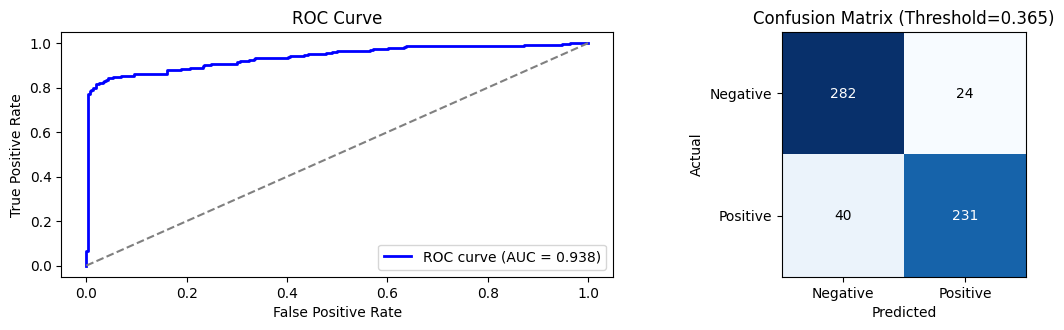

In [45]:
for clf in classifiers:
    print(f'Classificador: {clf}')

    if clf == classifiers[0]: # Logistic Regression
        th = 0.441
    
    elif clf == classifiers[1]: # KNN
        th = 0.6
    
    elif clf == classifiers[2]: # Gradient Boosting
        th = 0.365

    y_scores = clf.predict_proba(X_test)[:, 1]

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)

    # Calculate AUC (Area Under Curve)
    roc_auc = auc(fpr, tpr)

    final_result = evaluate_threshold(y_test, y_scores, th)

    # Visualize ROC curve and optimal thresholds
    plt.figure(figsize=(12, 6))

    # Plot ROC curve
    plt.subplot(2, 2, 1)
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")

    # Visualize ROC curve and optimal thresholds and plot confusion matrices for each threshold
    plt.subplot(2, 2, 2)
    plot_confusion_matrix(plt.gca(), final_result, f"Confusion Matrix (Threshold={th})")

    plt.tight_layout()

    # Print summary of results
    print("Avaliação final")
    print("-" * 50)

    print(final_result['classification_report'])

    # Show the plots
    plt.show()

### Análise dos resultados

- Observando os resultados na fase de teste, percebemos que os modelos, utilizando os thresholds ajustados durante o treinamento, mantiveram desempenhos bastante semelhantes aos obtidos anteriormente:

  - **Logistic Regression**:
    - AUC-ROC: **93% (treino)** / **91,6% (teste)**
    - Acurácia: **89% (treino)** / **87% (teste)**

  - **K-Nearest Neighbors (KNN)**:
    - AUC-ROC: **89,2% (treino)** / **89,8% (teste)**
    - Acurácia: **84% (treino)** / **85% (teste)**

  - **Gradient Boosting**:
    - AUC-ROC: **93,9% (treino)** / **93,8% (teste)**
    - Acurácia: **90% (treino)** / **89% (teste)**

- Esses resultados indicam que o processo de **treinamento** e a **seleção de thresholds ótimos** foram eficazes, permitindo que os modelos mantivessem um **bom poder preditivo** e **baixo erro de generalização** na avaliação final. Isso sugere que os modelos feitos não estão superajustados aos dados de treino e possuem boa capacidade de generalizar para novos dados não vistos.


## 2. Predição de preços de diamonds

### Descrição dos dados (Fonte: [Kaggle](https://www.kaggle.com/datasets/shivam2503/diamonds)):

- **price**: price in US dollars (\$326--\$18,823)

- **carat**: weight of the diamond (0.2--5.01)

- **cut**: quality of the cut (Fair, Good, Very Good, Premium, Ideal)

- **color**: diamond colour, from J (worst) to D (best)

- **clarity**: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

- **x**: length in mm (0--10.74)

- **y**: width in mm (0--58.9)

- **z**: depth in mm (0--31.8)

- **depth**: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)

- **table**: width of top of diamond relative to widest point (43--95)

### Análise Exploratória dos Dados

In [46]:
diamonds = pd.read_csv('diamonds.csv', index_col=0)
diamonds

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53936,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53937,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53938,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53939,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


In [47]:
diamonds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53940 entries, 1 to 53940
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.5+ MB


- Não há nenhum valor nulo que necessite de tratamento. 

- Pela descrição apontada no Kaggle, as três variáveis categóricas "cut", "color" e "clarity" são variáveis categóricas ordinais, então necessitam de um pré-processamento para codificá-las que leve em consideração a ordem, estando preparadas para a etapa de predição.

- A respeito das variáveis númericas, como se tratam de variáveis com diferença significativa de escala, pode interferir em algoritmos que são sensíveis a escala, como o KNN. Por isso, irei codificá-las utilizando o StandardScaler, assim como na questão 1 de predição de pagamento de empréstimos.

### Configurações experimentais (Pré-processamento)

In [48]:
# -------- TREINO E TESTE -------- #

# Divisão do conjunto de treino em X (features) e y (target)
X = diamonds.drop('price', axis=1)
y = diamonds['price']

# Criando uma lista de nomes das features númericas que irão ser codificadas com o StandardScaler
numerical_features = ['carat', 'depth', 'table', 'x', 'y', 'z']

# Criando uma lista de nomes das features categóricas ordinais que irão ser codificadas com o OrdinalEncoder
categorical_features = ['cut', 'color', 'clarity']

# Define a order para cada coluna categórica (Pior -> Melhor)
categories_order = [
    ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'],  # Ordem para 'cut' 
    ['J', 'I', 'H', 'G', 'F', 'E', 'D'],  # Ordem para 'color'
    ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']  # Ordem para 'clarity'
]

# Criando uma lista com o objetivo de cada algoritmo que será utilizado para realizar as predições 
regressors = [LinearRegression(), KNeighborsRegressor(), GradientBoostingRegressor(random_state=seed)]

# Divisão do conjunto de treino em treino/validação com uma porcentagem de treino em 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Etapa de transformação apenas das features númericas utilizando o StandardScaler
transformer = ColumnTransformer(transformers=[('scaler', StandardScaler(), numerical_features),
                                             ('ordinal_encoder', OrdinalEncoder(categories=categories_order), categorical_features)])

# # Realizando a transformação nas features de treino e validação da forma correta para evitar data leakage
X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)

### Modelagem preditiva

#### Treino e validação dos modelos

Regressor: LinearRegression()
----------------------------------------
R² Score: 0.906
RMSE: 1224.354



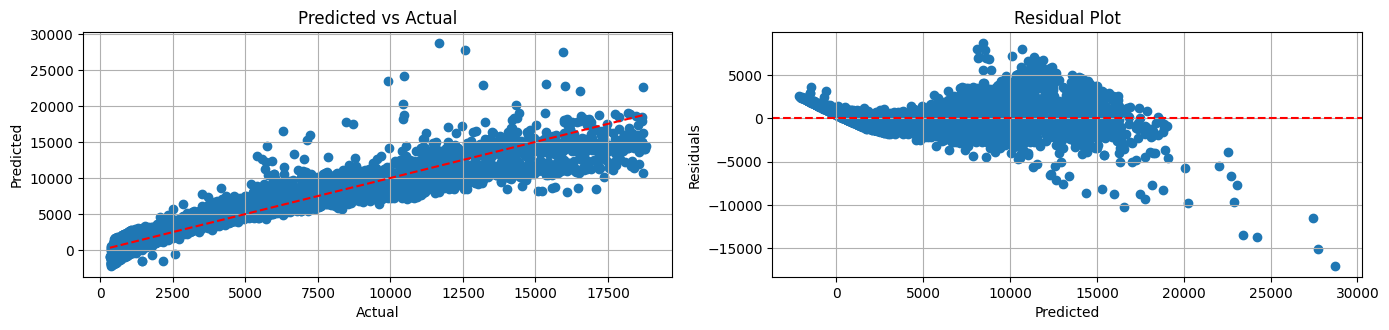

Regressor: KNeighborsRegressor()
----------------------------------------
R² Score: 0.968
RMSE: 709.596



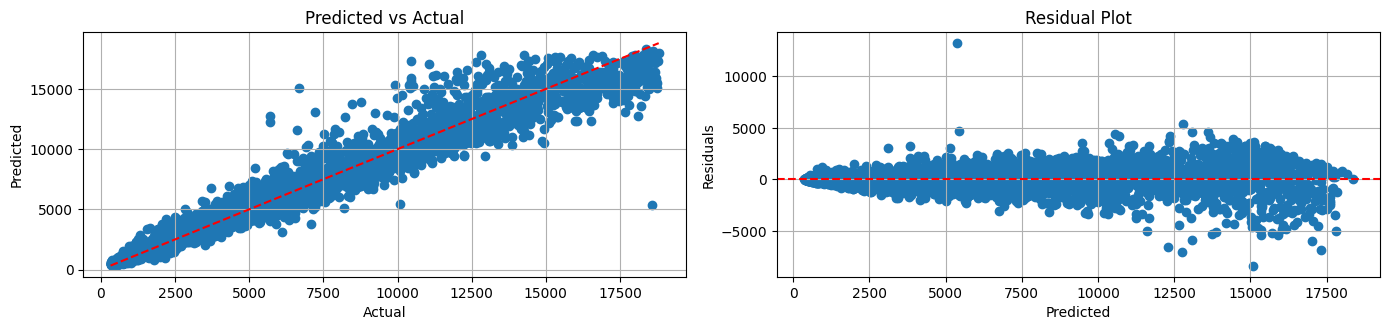

Regressor: GradientBoostingRegressor(random_state=123)
----------------------------------------
R² Score: 0.977
RMSE: 607.751



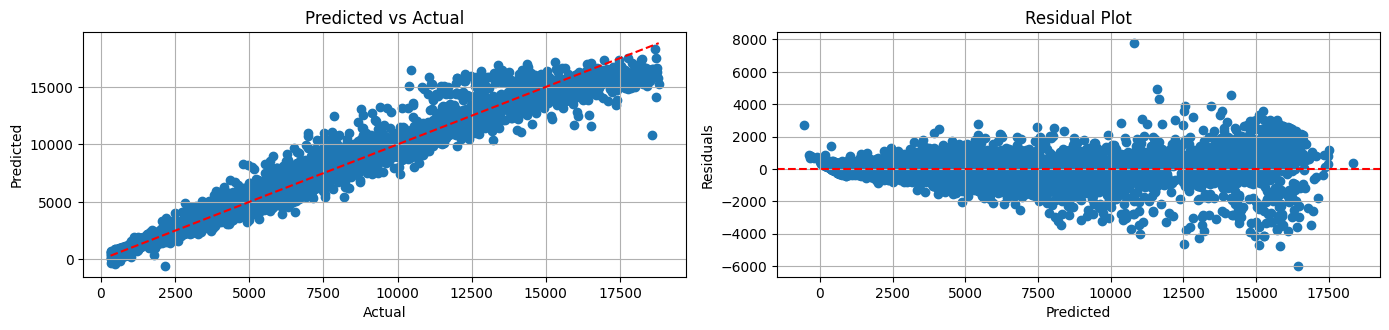

In [49]:
for rgs in regressors:
    
    print(f'Regressor: {rgs}')

    # Treino e predição
    rgs.fit(X_train, y_train)
    y_pred = rgs.predict(X_test)

    # Subplot 1: Predicted vs Actual
    plt.figure(figsize=(14, 6))
    plt.subplot(2, 2, 1)
    plt.scatter(y_test, y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Predicted vs Actual")
    plt.grid(True)

    # Subplot 2: Residual
    plt.subplot(2, 2, 2)
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title("Residual Plot")
    plt.grid(True)

    plt.tight_layout()

    # Validação
    print("-" * 40)
    print(f'R² Score: {round(r2_score(y_test, y_pred), 3)}')
    print(f'RMSE: {round(np.sqrt(mean_squared_error(y_test, y_pred)), 3)}\n')

    # Show the plots
    plt.show()

### Análise dos resultados

- Dentre os algoritmos utilizados para predição, os melhores resultadores foram: GradientBoostingRegressor > KNeighborsRegressor > LinearRegression. Sobre o melhor modelo resultado desempenhado, o GradientBoostingRegressor obteve um R² de 0.977, indicando que explica 97.7% da variância da variável alvo, e um RMSE de 607.751, o que representa um erro médio relativamente baixo considerando a escala dos dados. Esses resultados sugerem que o modelo tem excelente capacidade preditiva, ajustando-se bem aos dados.

- Pode-se notar que no primeiro plot "Predicted vs Actual", os pontos azuis se tornam cada vez mais próximos da linha azul, o que indica uma melhor predição do modelo que se aproxima dos dados reais e por isso que obteve um erro médio baixo. Além disso, a análise do gráfico de resíduos reforça a qualidade do modelo, já que os resíduos estão concentrados ao redor de zero, indicando previsões mais precisas e com baixo resíduo entre os valores reais e previstos.

## 3. Conjuntos desbalanceados - parte I

#### Transformação das variáveis-alvo em binária

In [50]:
filename = 'A652.pickle'

f = open(filename, 'rb')

(X_train, y_train, X_val, y_val, X_test, y_test) = pickle.load(f)
print("Shapes: ", X_train.shape, X_val.shape, X_test.shape)

Shapes:  (10012, 24) (2506, 24) (9582, 24)


In [51]:
pd.DataFrame(y_train).value_counts()

0   
0.0     9258
0.2      190
0.4       88
0.6       75
0.8       55
        ... 
19.0       1
19.6       1
23.8       1
30.0       1
32.6       1
Name: count, Length: 74, dtype: int64

- Como informado no enunciado, as variáveis y_* possuem valores contínuos, como o exemplo do y_train acima. Porém, o propósito do exercício é transformar o problema de regressão em classificação, logo, transformar os alvos y_* em binários 0 ou 1, seguindo o critério descrito.

In [52]:
y_train = (y_train != 0).astype(int) # transformando target do conjunto de treino em binário
y_val = (y_val != 0).astype(int) # target do conjunto de validação em binário
y_test = (y_test != 0).astype(int) # target do conjunto de validação em binário

- Conforme dito no enunciado, acima foram feita a etapa de tornar o target de valores contínuos para 0 ou 1, para cada y_*. Nesse processo, associou-se ao rótulo 0 qualquer valor que já fosse 0, enquanto que o restante se tornou 1.

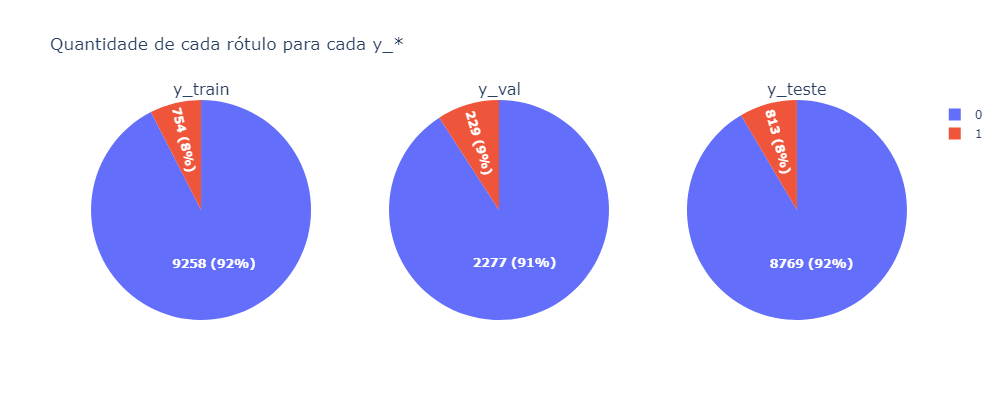

In [53]:
# Criando os subplots
fig = sp.make_subplots(
    rows=1, cols=3,
    subplot_titles=['y_train', 'y_val', 'y_teste'],
    specs=[[{'type': 'domain'}, {'type': 'domain'}, {'type': 'domain'}]]
)

# Primeiro subplot
fig.add_trace(go.Pie(labels=pd.DataFrame(y_train).value_counts().index, values=pd.DataFrame(y_train).value_counts(), textinfo='value+percent',
                     texttemplate='%{value:.0f} (%{percent:.0%})', textfont=dict(color='white', weight='bold')), row=1, col=1)

# Segundo subplot
fig.add_trace(go.Pie(labels=pd.DataFrame(y_val).value_counts().index, values=pd.DataFrame(y_val).value_counts(), textinfo='value+percent',
                     texttemplate='%{value:.0f} (%{percent:.0%})', textfont=dict(color='white', weight='bold')), row=1, col=2)

# Terceiro subplot
fig.add_trace(go.Pie(labels=pd.DataFrame(y_test).value_counts().index, values=pd.DataFrame(y_test).value_counts(), textinfo='value+percent',
                     texttemplate='%{value:.0f} (%{percent:.0%})', textfont=dict(color='white', weight='bold')), row=1, col=3)

# Atualizando layout com rótulos dos eixos e exibição do gráfico
fig.update_layout(height=400, width=1000, title = 'Quantidade de cada rótulo para cada y_*')
fig.show('png')

- Nitidamente, pode-se observar que há um grande desbalanceamento de classes nas 3 porções divididas do conjunto de dados com uma predominância de valores com rótulo 0.

### Modelagem preditiva

#### Função que será usada nessa etapa para avaliar os modelos

In [54]:
def plot_confusion_matrix_class_report(y_test, y_pred):
    #Confusion metrics of the model built on down-sampled data
    conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

    fig, ax = plt.subplots(figsize=(3, 3))
    ax.matshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', color="white" if conf_matrix[i, j] > conf_matrix.max()/2 else "black")
    
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()

    print(classification_report(y_test, y_pred))

#### Baseline

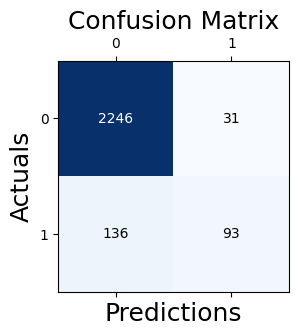

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      2277
           1       0.75      0.41      0.53       229

    accuracy                           0.93      2506
   macro avg       0.85      0.70      0.75      2506
weighted avg       0.93      0.93      0.92      2506



In [55]:
model = GradientBoostingClassifier(random_state=seed)

# Treino e predição
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

plot_confusion_matrix_class_report(y_val, y_pred)

#### Undersampling aleatório (50/50)

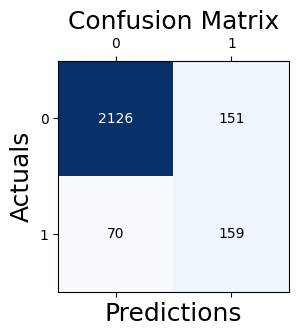

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      2277
           1       0.51      0.69      0.59       229

    accuracy                           0.91      2506
   macro avg       0.74      0.81      0.77      2506
weighted avg       0.93      0.91      0.92      2506



In [56]:
pipeline_undersampling = Pipeline([
            ('sampler', RandomUnderSampler(sampling_strategy=0.5, random_state=seed)),
            ('model', GradientBoostingClassifier(random_state=seed))
        ])

# Treino e predição
pipeline_undersampling.fit(X_train, y_train)
y_pred = pipeline_undersampling.predict(X_val)

plot_confusion_matrix_class_report(y_val, y_pred)

#### Oversampling aleatório (50/50)

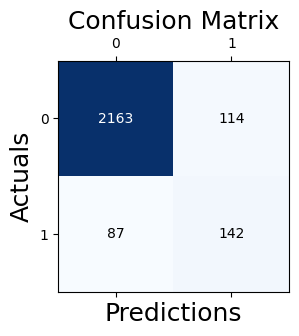

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      2277
           1       0.55      0.62      0.59       229

    accuracy                           0.92      2506
   macro avg       0.76      0.79      0.77      2506
weighted avg       0.92      0.92      0.92      2506



In [57]:
pipeline_oversampling = Pipeline([
            ('sampler', RandomOverSampler(sampling_strategy=0.5, random_state=seed)),
            ('model', GradientBoostingClassifier(random_state=seed))
        ])

# Treino e predição
pipeline_oversampling.fit(X_train, y_train)
y_pred = pipeline_oversampling.predict(X_val)

plot_confusion_matrix_class_report(y_val, y_pred)

#### Alteração de Threshold (Reutilizei funções da Parte 1)

Youden's J
              precision    recall  f1-score   support

           0       0.98      0.86      0.92      2277
           1       0.38      0.85      0.52       229

    accuracy                           0.86      2506
   macro avg       0.68      0.86      0.72      2506
weighted avg       0.93      0.86      0.88      2506

Closest to (0,1)
              precision    recall  f1-score   support

           0       0.98      0.86      0.92      2277
           1       0.38      0.85      0.52       229

    accuracy                           0.86      2506
   macro avg       0.68      0.86      0.72      2506
weighted avg       0.93      0.86      0.88      2506



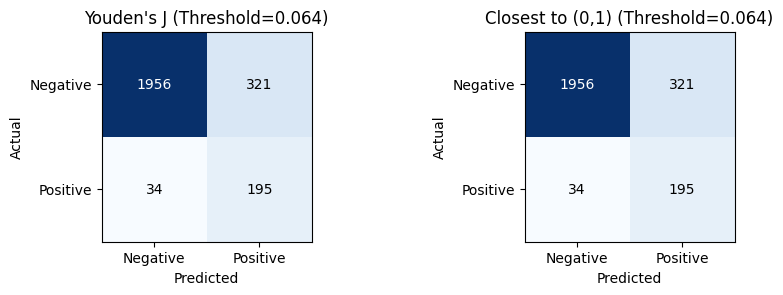

In [58]:
model = GradientBoostingClassifier(random_state=seed)

model.fit(X_train, y_train)

y_scores = model.predict_proba(X_val)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_scores)

# Find optimal thresholds
optimal_thresholds = find_optimal_threshold(fpr, tpr, thresholds)

youden_results = evaluate_threshold(y_val, y_scores, optimal_thresholds["youden"][0])
closest_results = evaluate_threshold(y_val, y_scores, optimal_thresholds["closest"][0])

plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plot_confusion_matrix(plt.gca(), youden_results, f"Youden's J (Threshold={optimal_thresholds['youden'][0]:.3f})")

plt.subplot(2, 2, 2)
plot_confusion_matrix(plt.gca(), closest_results, f"Closest to (0,1) (Threshold={optimal_thresholds['closest'][0]:.3f})")

print("Youden's J")
print(youden_results['classification_report'])

print("Closest to (0,1)")
print(closest_results['classification_report'])

#### Análise dos resultados

- Para fins de comparação, o *baseline* foi criado apenas com o treinamento e validação, sem nenhuma estratégia aplicada, o que resultou em um F1-score de 0,53 na classe positiva. Para esta análise, focarei exclusivamente na classe positiva, utilizando o F1-score, que é uma métrica adequada para cenários desbalanceados por representar a média harmônica entre precisão e recall. Por esse motivo, não será utilizada a acurácia, pois trata-se de uma métrica que pode indicar resultados enganosos em conjuntos desbalanceados por haver uma quantidade exorbitante de verdadeiro negativos e gerar um modelo tendencioso à classe negativa, majoritariamente.

- Comparando os resultados das estratégias aplicadas nesta etapa de treino e validação, a melhor performance foi obtida tanto com *undersampling* quanto com *oversampling*, ambas ajustando o equilíbrio para 50% da classe 0 e 50% da classe 1. Dessa forma, ambas atingiram um F1-score de **59%** na classe positiva, representando um aumento de 6% em relação ao *baseline*. Por serem os melhores resultados, realizarei uma avaliação final com essas duas técnicas, a fim de analisar qual delas apresenta o melhor desempenho no conjunto de teste.

### Avaliação Final dos modelos

#### Undersampling aleatório (50/50)

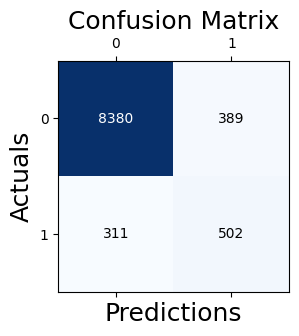

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      8769
           1       0.56      0.62      0.59       813

    accuracy                           0.93      9582
   macro avg       0.76      0.79      0.77      9582
weighted avg       0.93      0.93      0.93      9582



In [59]:
y_pred = pipeline_undersampling.predict(X_test)

plot_confusion_matrix_class_report(y_test, y_pred)

#### Oversampling aleatório (50/50)

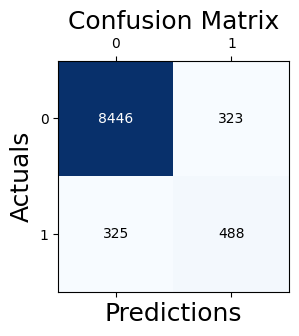

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      8769
           1       0.60      0.60      0.60       813

    accuracy                           0.93      9582
   macro avg       0.78      0.78      0.78      9582
weighted avg       0.93      0.93      0.93      9582



In [60]:
y_pred = pipeline_oversampling.predict(X_test)

plot_confusion_matrix_class_report(y_test, y_pred)

- Pelos resultados, assim como observado na etapa de treino e validação, os modelos com *undersampling* e *oversampling* continuaram apresentando desempenhos mais satisfatórios. Nesta etapa final de teste, o *undersampling* obteve um F1-score na classe positiva **1% maior** que o *oversampling*, mantendo o mesmo resultado alcançado durante o treino e validação. Isso indica que o modelo, ao utilizar essas técnicas de balanceamento, está generalizando bem, com um erro de generalização baixo.

## 4. Conjuntos desbalanceados - parte II

## 5. Calibração de modelos

## 6. Validação cruzada aninhada